# 2022-09-26 Stiffness

## Last time

* Stability diagrams
* Energy dissipation
* Exploring the $\theta$ method
* PDE at ODE

## Today

* Advection-diffusion
* $A$- and $L$-stability
* Spatial, temporal, and physical dissipation
* Stiffness

In [21]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function plot_stability(Rz, title; xlims=(-3, 3), ylims=(-2, 2))
    x = LinRange(xlims[1], xlims[2], 100)
    y = LinRange(ylims[1], ylims[2], 100)
    heatmap(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2), aspect_ratio=:equal, title=title)
end

function ode_theta_linear(A, u0; forcing=zero, tfinal=1, h=0.1, theta=.5)
    u = copy(u0)
    t = 0.
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        rhs = (I + h*(1-theta)*A) * u .+ h*forcing(t+h*theta)
        u = (I - h*theta*A) \ rhs
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

Rz_theta(z, theta) = (1 + (1 - theta)*z) / (1 - theta*z)

Rz_theta (generic function with 1 method)

# Advection as linear ODE

In [22]:
function advect_matrix(n; upwind=false)
    dx = 2 / n
    rows = [1]
    cols = [1]
    vals = [0.]
    wrap(j) = (j + n - 1) % n + 1
    for i in 1:n
        append!(rows, [i, i])
        if upwind
            append!(cols, wrap.([i-1, i]))
            append!(vals, [1., -1] ./ dx)
        else
            append!(cols, wrap.([i-1, i+1]))
            append!(vals, [1., -1] ./ 2dx)
        end
    end
    sparse(rows, cols, vals)
end
eigvals(Matrix(advect_matrix(10)))

10-element Vector{ComplexF64}:
                    0.0 - 2.938926261462368im
                    0.0 - 2.9389262614623664im
                    0.0 - 1.2560848302247556e-16im
                    0.0 + 1.2560848302247556e-16im
                    0.0 + 2.9389262614623664im
                    0.0 + 2.938926261462368im
   4.81482486096809e-34 - 4.755282581475769im
   4.81482486096809e-34 + 4.755282581475769im
 3.0814879110195774e-33 - 4.7552825814757655im
 3.0814879110195774e-33 + 4.7552825814757655im

  0.035987 seconds (78.89 k allocations: 6.054 MiB, 92.42% compilation time)


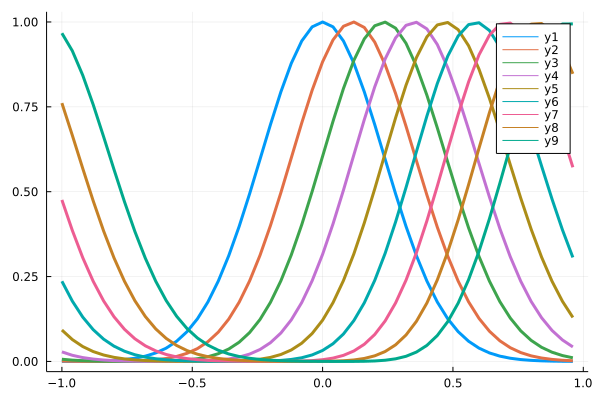

In [23]:
n = 50
A = advect_matrix(n, upwind=false)
x = LinRange(-1, 1, n+1)[1:end-1]
u0 = exp.(-9 * x .^ 2)
@time thist, uhist = ode_theta_linear(A, u0, h=.04, theta=0.5, tfinal=1.);
nsteps = size(uhist, 2)
plot(x, uhist[:, 1:(nsteps÷8):end])

# Heat equation as linear ODE

* How do different $\theta \in [0, 1]$ compare in terms of stability?
* Are there artifacts even when the solution is stable?

In [24]:
function heat_matrix(n)
    dx = 2 / n
    rows = [1]
    cols = [1]
    vals = [0.]
    wrap(j) = (j + n - 1) % n + 1
    for i in 1:n
        append!(rows, [i, i, i])
        append!(cols, wrap.([i-1, i, i+1]))
        append!(vals, [1, -2, 1] ./ dx^2)
    end
    sparse(rows, cols, vals)
end
heat_matrix(5)

5×5 SparseMatrixCSC{Float64, Int64} with 15 stored entries:
 -12.5     6.25     ⋅       ⋅      6.25
   6.25  -12.5     6.25     ⋅       ⋅ 
    ⋅      6.25  -12.5     6.25     ⋅ 
    ⋅       ⋅      6.25  -12.5     6.25
   6.25     ⋅       ⋅      6.25  -12.5

  0.036457 seconds (75.67 k allocations: 4.493 MiB, 96.12% compilation time)


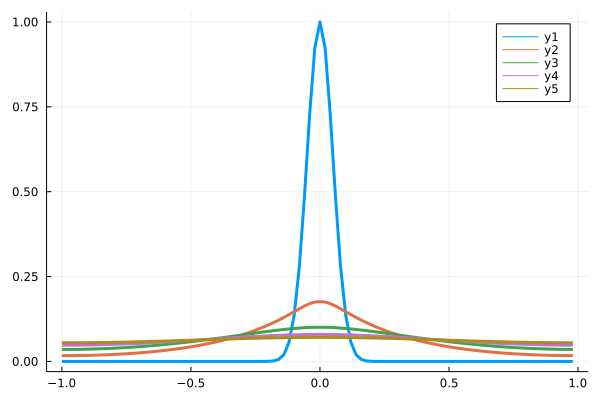

In [25]:
n = 100
A = heat_matrix(n)
x = LinRange(-1, 1, n+1)[1:end-1]
u0 = exp.(-200 * x .^ 2)
@time thist, uhist = ode_theta_linear(A, u0, h=.1, theta=1, tfinal=1);
nsteps = size(uhist, 2)
plot(x, uhist[:, 1:5])

# Stability classes and the $\theta$ method


## Definition: $A$-stability
A method is $A$-stable if the stability region
$$ \{ z : |R(z)| \le 1 \} $$
contains the entire left half plane $$ \Re[z] \le 0 .$$
This means that the method can take arbitrarily large time steps without becoming unstable (diverging) for any problem that is indeed physically stable.

## Definition: $L$-stability
A time integrator with stability function $R(z)$ is $L$-stable if
$$ \lim_{z\to\infty} R(z) = 0 .$$
For the $\theta$ method, we have
$$ \lim_{z\to \infty} \frac{1 + (1-\theta)z}{1 - \theta z} = \frac{1-\theta}{\theta} . $$
Evidently only $\theta=1$ is $L$-stable.

# Spectrum of operators

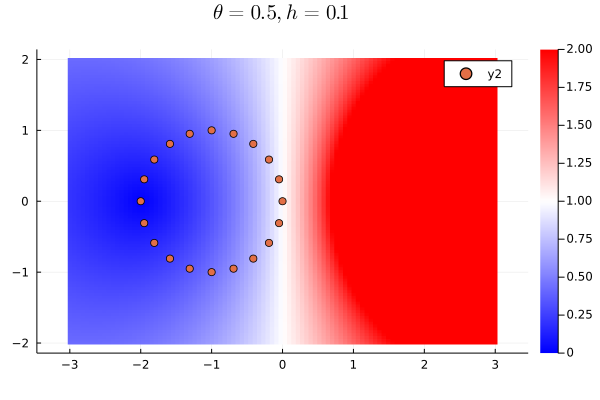

In [26]:
theta=.5
h = .1
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta, h=$h\$")
ev = eigvals(Matrix(h*advect_matrix(20, upwind=true)))
scatter!(real(ev), imag(ev))

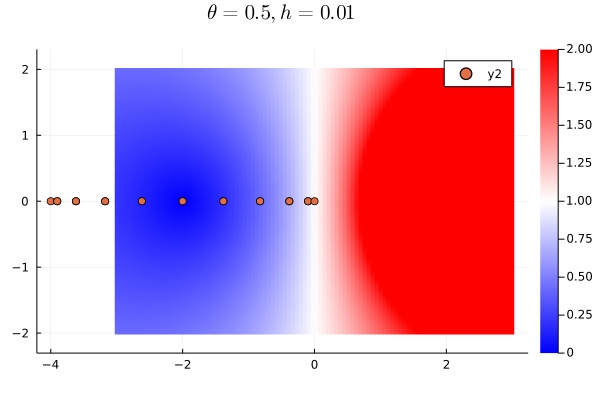

In [27]:
theta=.5
h = .01
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta, h=$h\$")
ev = eigvals(Matrix(h*heat_matrix(20)))
scatter!(real(ev), imag(ev))

# Advection-diffusion as linear ODE

\begin{align}
(-\kappa u_x + w u)_x &= 0 & Pe_L &= \frac{L \lvert w \rvert}{\kappa}
\end{align}

In [28]:
function advdiff_matrix(n; kappa=1, wind=1, upwind=0.)
    dx = 2 / n
    rows = [1]
    cols = [1]
    vals = [0.]
    wrap(j) = (j + n - 1) % n + 1
    for i in 1:n
        append!(rows, [i, i, i])
        append!(cols, wrap.(i-1:i+1))
        diffuse = [-1, 2, -1] * kappa / dx^2
        advect_upwind = [-1, 1, 0] * wind / dx
        advect_center = [-1, 0, 1] * wind / 2dx
        stencil = -diffuse - upwind * advect_upwind - (1 - upwind) * advect_center
        append!(vals, stencil)
    end
    sparse(rows, cols, vals)
end
advdiff_matrix(5, kappa=.1)

5×5 SparseMatrixCSC{Float64, Int64} with 15 stored entries:
 -1.25   -0.625    ⋅       ⋅      1.875
  1.875  -1.25   -0.625    ⋅       ⋅ 
   ⋅      1.875  -1.25   -0.625    ⋅ 
   ⋅       ⋅      1.875  -1.25   -0.625
 -0.625    ⋅       ⋅      1.875  -1.25

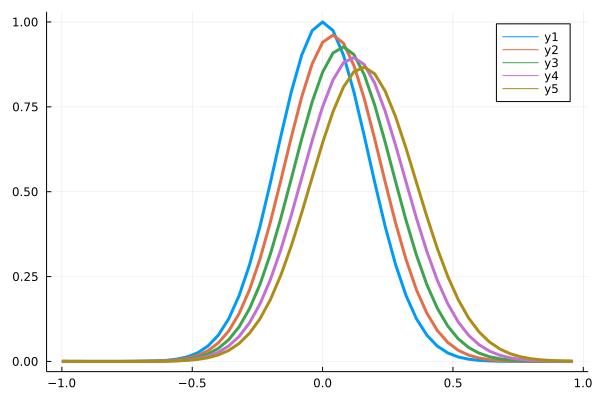

In [29]:
n = 50
A = advdiff_matrix(n, kappa=1/30, upwind=0)
x = LinRange(-1, 1, n+1)[1:end-1]
u0 = exp.(-16 * x .^ 2)
thist, uhist = ode_theta_linear(A, u0, h=.04, theta=.5)
plot(x, uhist[:, 1:5])

# Explain the mechanism and obstacles to fixing

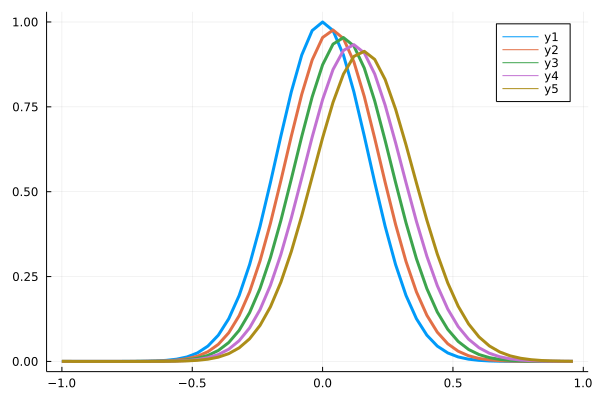

In [30]:
A = advdiff_matrix(50, kappa=.02, upwind=0)
thist, uhist = ode_theta_linear(A, u0, h=.04, theta=.5, tfinal=1.);
plot(x, uhist[:, 1:5])

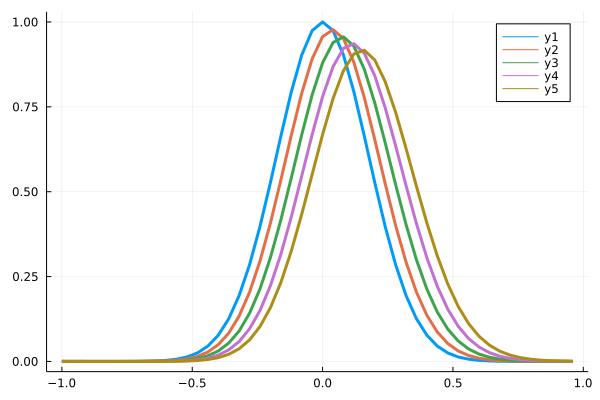

In [31]:
A = advdiff_matrix(50, kappa=0, upwind=0)
thist, uhist = ode_theta_linear(A, u0, h=.04, theta=1, tfinal=1.)
plot(x, uhist[:, 1:5])

# Explain the mechanism

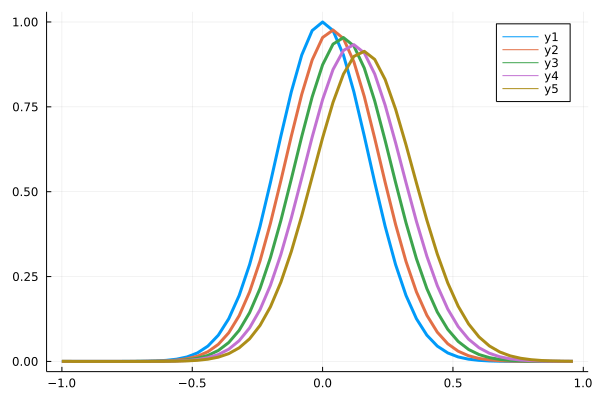

In [32]:
A = advdiff_matrix(50, kappa=.02, upwind=0)
thist, uhist = ode_theta_linear(A, u0, h=.04, theta=.5, tfinal=1.);
plot(x, uhist[:, 1:5])

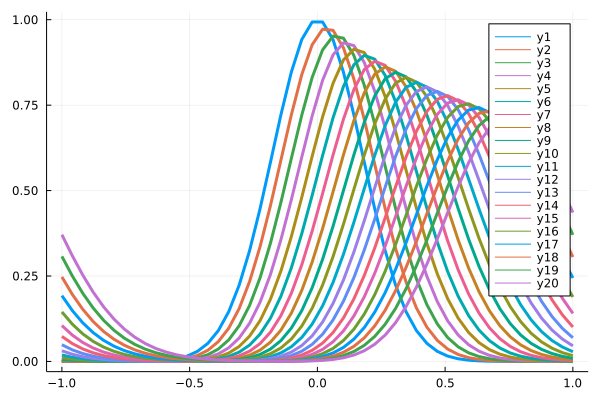

In [33]:
n = 50
A = advdiff_matrix(n, kappa=0, upwind=0)
x = LinRange(-1, 1, n)
u0 = exp.(-16 * x .^ 2)
thist, uhist = ode_theta_linear(A, u0, h=.04, theta=1, tfinal=1.)
plot(x, uhist[:, 1:20])

# Stability limits: CFL principle for advection

> A stable method must be capable of propagating information at least as fast as the continuous system it discretizes.

* Courant, Friedrichs, Levy (1928)
* Discrete information moves at most $\Delta x$ in time $\Delta t$ (with explicit integrator)
* Physical information moves distance $|w| \Delta t$
* "CFL number" or "Courant number"
$$ \textrm{CFL} = \frac{\Delta t |w|}{\Delta x} \le 1 $$
* What does this mean for implicit methods?

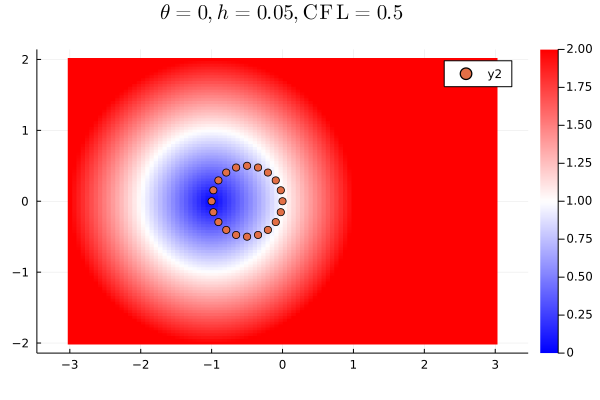

In [34]:
theta=0
n = 20
dx = 2 / n
cfl = .5
h = cfl * dx / 1

plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta, h=$h, \\mathrm{CFL}=$cfl\$")
ev = eigvals(Matrix(h*advdiff_matrix(n, kappa=0, upwind=1)))
scatter!(real(ev), imag(ev))

# Stability limits: explicit diffusion

* The diffusion operator has stencil
$$ \frac{\kappa}{(\Delta x)^2} \begin{bmatrix} 1 & -2 & 1 \end{bmatrix} $$
* Apply this to test function $e^{i\theta x}$ to get the symbol
\begin{align}
L_{\Delta x} e^{i\theta x}
&=
\frac{\kappa}{(\Delta x)^2} \Big[ e^{-i\theta\Delta x} - 2 + e^{i\theta\Delta x} \Big] e^{i\theta x} \\
&= \frac{2\kappa}{(\Delta x)^2} \underbrace{\Big[ \cos (\theta \Delta x) - 1 \Big]}_{\min = -2} e^{i\theta x}
\end{align}
* Conclude $\frac{-4 \kappa}{(\Delta x)^2} \le \lambda \le 0$, need $-2 \le h\lambda \le 0$ for Euler

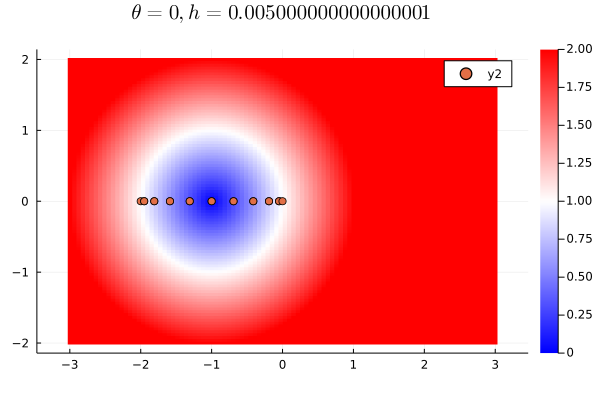

In [35]:
theta=0
n = 20
dx = 2 / n
kappa = 1
lambda_min = -4 * kappa / dx^2
h = -2 / lambda_min

plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta, h=$h\$")
ev = eigvals(Matrix(h*advdiff_matrix(n, kappa=kappa, wind=0)))
scatter!(real(ev), imag(ev))

# Stiffness

> Stiff equations are problems for which explicit methods don't work. (Hairer and Wanner, 2002)

* "stiff" dates to Curtiss and Hirschfelder (1952)

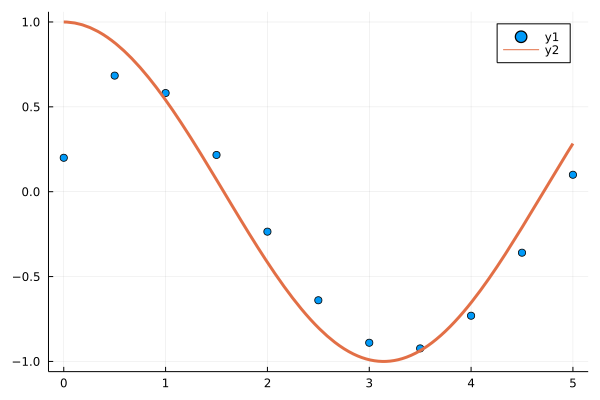

In [36]:
k = 5
thist, uhist = ode_theta_linear(-k, [.2], forcing=t -> k*cos(t), tfinal=5, h=.5, theta=1)
scatter(thist, uhist[1,:])
plot!(cos)

In [37]:
function mms_error(h; theta=.5, k=10)
    u0 = [.2]
    thist, uhist = ode_theta_linear(-k, u0, forcing=t -> k*cos(t), tfinal=3, h=h, theta=theta)
    T = thist[end]
    u_exact = (u0 .- k^2/(k^2+1)) * exp(-k*T) .+ k*(sin(T) + k*cos(T))/(k^2 + 1)
    uhist[1,end] .- u_exact
end

mms_error (generic function with 1 method)

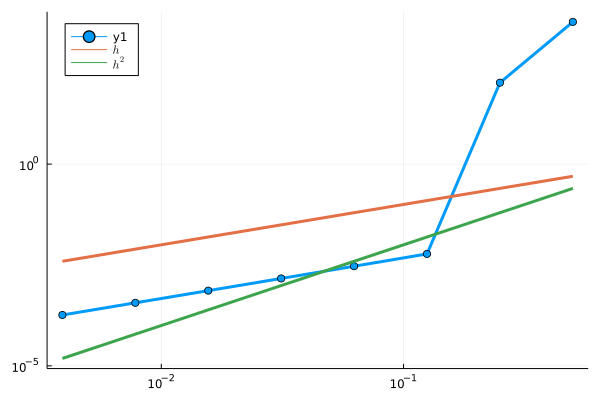

In [43]:
hs = .5 .^ (1:8)
errors = mms_error.(hs, theta=0, k=10)
plot(hs, norm.(errors), marker=:circle, xscale=:log10, yscale=:log10)
plot!(hs, hs, label="\$h\$", legend=:topleft)
plot!(hs, hs.^2, label="\$h^2\$")


## Discuss: is advection-diffusion stiff?

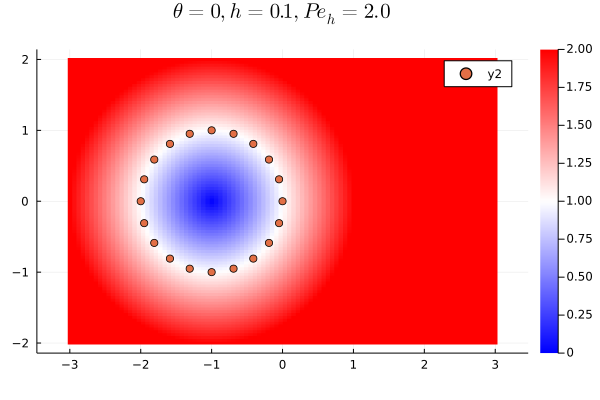

In [39]:
theta=0
n = 20
dx = 2 / n
kappa = .05
lambda_min = -4 * kappa / dx^2
cfl = 1
h = min(-2 / lambda_min, cfl * dx)

plot_stability(z -> Rz_theta(z, theta),
    "\$\\theta=$theta, h=$h, Pe_h = $(h/kappa)\$")
ev = eigvals(Matrix(h*advdiff_matrix(n, kappa=kappa, wind=1)))
scatter!(real(ev), imag(ev))

# Cost scaling

* Spatial discretization with error $O((\Delta x)^p)$
* Time discretization with error $O((\Delta t)^q)$

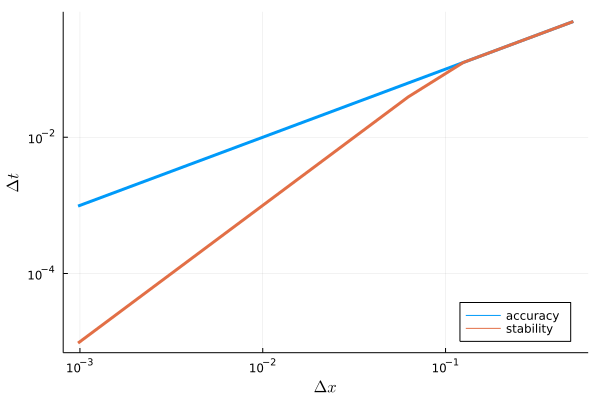

In [127]:
p = 2   # spatial order of accuracy
q = 2   # temporal order of accuracy
Pe = 10 # Peclet number with wind=1

dt_accuracy(dx) = dx .^ (p/q)
dt_stability(dx) = min(dx, Pe * dx ^ 2)

plot(dx, [dt_accuracy.(dx) dt_stability.(dx)],
    label=["accuracy" "stability"], 
    xscale=:log10, yscale=:log10, legend=:bottomright,
    xlabel="\$\\Delta x\$", ylabel="\$\\Delta t\$")

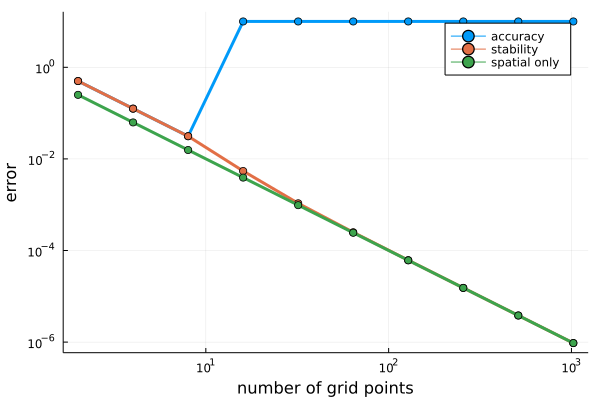

In [128]:
n = 2 .^ (1:10); dx = 1 ./ n
function error((dx, dt))
    dt <= dt_stability(dx) ? dx ^ p + dt ^ q : 10
end
plot(n, [error.(zip(dx, dt_accuracy.(dx))) error.(zip(dx, dt_stability.(dx))) dx.^p],
    label=["accuracy" "stability" "spatial only"],
    marker=:circle, xscale=:log10, yscale=:log10,
    xlabel="number of grid points", ylabel="error")

# Work-precision (error vs cost)

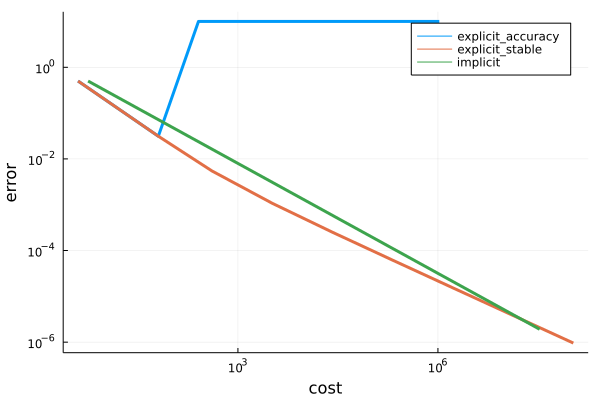

In [172]:
p = 2
q = 2
Pe = 10
dt = [dt_accuracy.(dx) dt_stability.(dx) dt_accuracy.(dx)]
c = [n./dt[:,1] n./dt[:,2] (n.^1.5)./dt[:,3]] # O(n^1.5 solve cost)
e = [error.(zip(dx, dt[:,1])) error.(zip(dx, dt[:,2])) dx.^p+dt[:,3].^q]
plot(c, e, xscale=:log10, yscale=:log10,
  label=["explicit_accuracy" "explicit_stable" "implicit"], xlabel="cost", ylabel="error")

* Stability can be an extreme demand for explicit methods
* Order of accuracy matters; usually balance spatial order $p$ and temporal order $q$
* Actual cost depends heavily on solver efficiency: O(n) vs O(n^2)
* "Constants matter"